In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.optim as optim
import torch.nn as nn
import cv2
# from torchinfo import summary
from torch.utils.data import DataLoader, Dataset, TensorDataset, WeightedRandomSampler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import torchvision.transforms as transforms
import torch.nn.functional as F

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Unzip the dataset
!unzip /content/drive/MyDrive/FH_detection_data.zip -d /content/

# Dataset paths and labels
train_data_path = "/content/train"
valid_data_path = "/content/valid"
train_label = pd.read_csv('/content/train/_classes.csv')
valid_label = pd.read_csv('/content/valid/_classes.csv')
#test_image_paths = "/content/FH_detection_data1.0/Step7/"


# **#2 Data Exploration**
1. Load dataset into a pandas DataFrame.

2. Display display three sample images from each class

3. Create separately class distribution plots of the train and validation data

❓ Why is it important to check for class imbalance before training? How might this affect our model?

✅ Class imbalance can lead to a biased predictions and learning of the data. Where it could lean towards predicting the more frequent class, since this would cause a minimiztion in loss which is what the haol would be. It would also lead to poor generalization, meaning the model may not learn crcial patters of the minority class due to fewer examples.



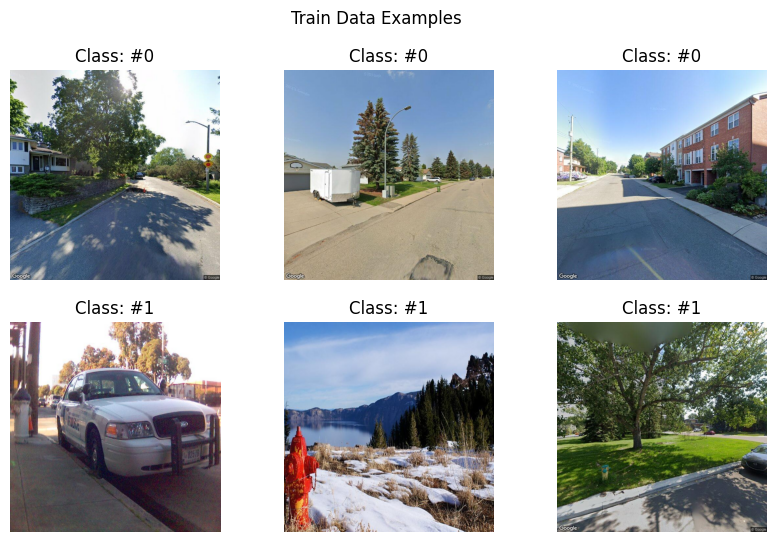

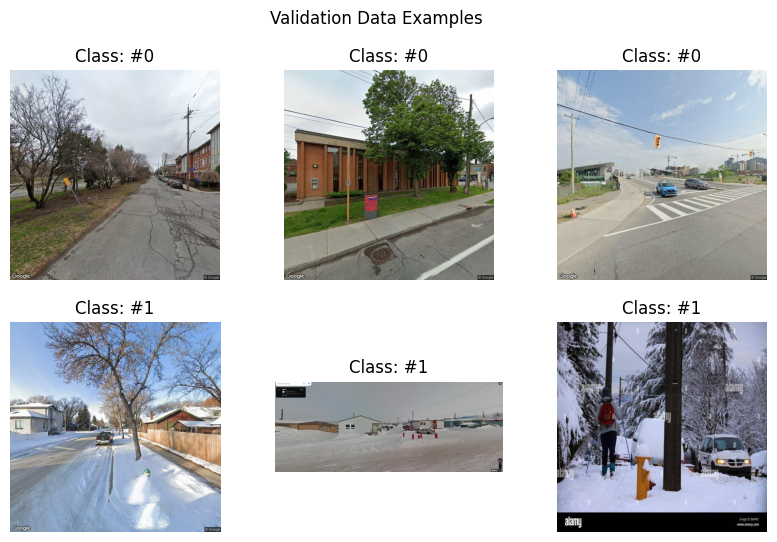

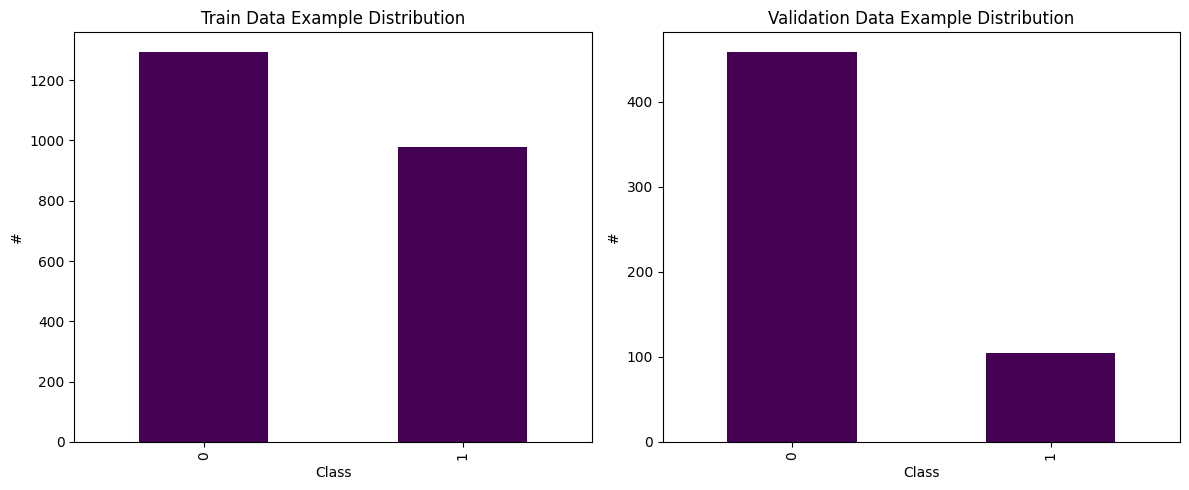

In [7]:
# Function to display 3 sample images per class
def sample_images(data_path, df, title):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
    class_labels = df["Fire Hydrants"].unique()

    # Loop through two classes
    for i, label in enumerate(class_labels[:2]):
        class_images = df.loc[df["Fire Hydrants"] == label, "filename"].sample(n=3, random_state=123).tolist()

        for j, image_name in enumerate(class_images):
            img_path = os.path.join(data_path, image_name)
            new_img = cv2.imread(img_path)
            new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)

            axes[i, j].imshow(new_img)
            axes[i, j].set_title(f"Class: #{label}")
            axes[i, j].axis("off")

    plt.suptitle(title)
    plt.show()

sample_images(train_data_path, train_label, "Train Data Examples")
sample_images(valid_data_path, valid_label, "Validation Data Examples")


# Distribution Plots
# # Plotting the class distribution for both train and validation data
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Train Data Distribution
train_label["Fire Hydrants"].value_counts().plot(kind="bar", ax=ax[0], colormap="viridis", title="Train Data Example Distribution")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("#")

# Validation Data Distribution
valid_label["Fire Hydrants"].value_counts().plot(kind="bar", ax=ax[1],  colormap="viridis", title="Validation Data Example Distribution")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("#")

plt.tight_layout()
plt.show() # show the plots

# **#3 Reprocessing**

1. Resize the images to 128x128

2. Apply any other necessary techniques

❓ Would one-hot encoding be necessary for binary classification? Why or why not?

✅ It wouldn't be necessary a single output neuron with a sigmoid actvation function would be sufficient. Though it would be required in deeper learning models, which are structured for multi-class problems.

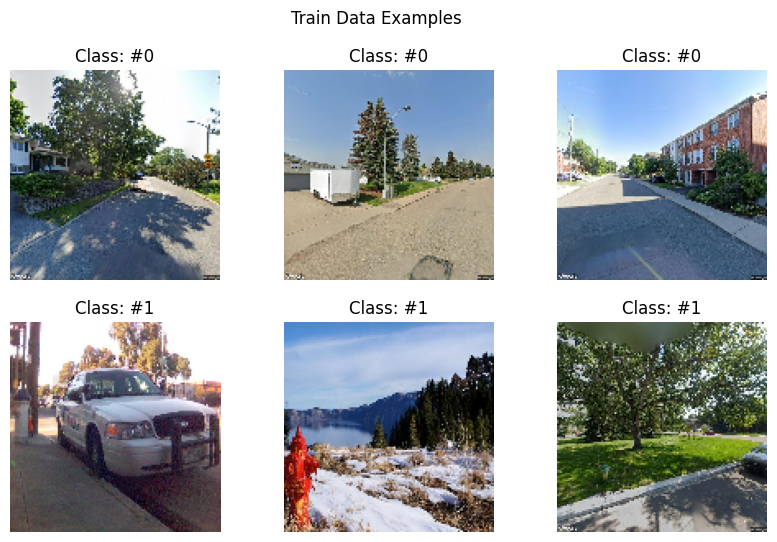

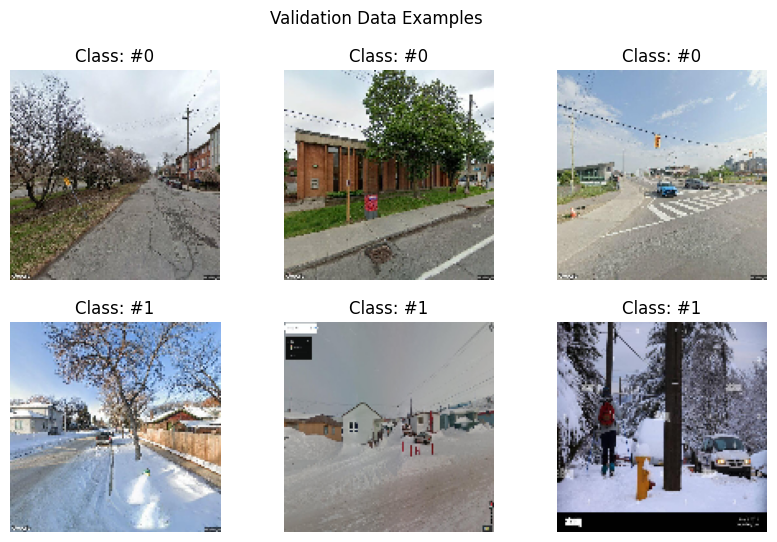

In [12]:
def preprocessing(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image {image_path}")
        return None
    img = cv2.resize(img, (128, 128))
    return img


def sample_images(data_path, df, title):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
    class_labels = df["Fire Hydrants"].unique()


    for i, label in enumerate(class_labels[:2]):
        class_images = df.loc[df["Fire Hydrants"] == label, "filename"].sample(n=3, random_state=123).tolist()

        for j, image_name in enumerate(class_images):
            img_path = os.path.join(data_path, image_name)
            new_img = preprocessing(img_path)

            if new_img is None:
                continue

            new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(new_img)
            axes[i, j].set_title(f"Class: #{label}")
            axes[i, j].axis("off")

    plt.suptitle(title)
    plt.show()

sample_images(train_data_path, train_label, "Train Data Examples")
sample_images(valid_data_path, valid_label, "Validation Data Examples")

# **#4 Reprocessing**

1. Create a CNN with:

- Two convolutional layers to extract features from the images.
- Max pooling layers after each convolution to reduce spatial dimensions.
- Fully connected layers to perform classification.
- A sigmoid activation function at the output layer to output a probability between 0 and 1.

2. Required architecture:

- Input: RGB images resized to 128x128 pixels.
- Conv2d (3 input channels, 32 output channels, kernel size 3, padding 1)
- MaxPool2d (kernel size 2, stride 2, padding 0) – applied after the first Conv2d.
- Conv2d (32 input channels, 64 output channels, kernel size 3, padding 1)
- MaxPool2d (kernel size 2, stride 2, padding 0) – applied after the second Conv2d.
- Flatten
- Linear layer with 128 units
- Output Linear layer with 1 unit and sigmoid activation


❓ List three ways to improve the baseline model (e.g., adding dropout to... , using batch normalization to..., or increasing the number of layers to..., be sure to come up with your own ideas!). Provide a brief explanation for each.

✅ Dropout Layer: where a fraction of nuerons are set to 0 (dropped out), this would force the model to learn more of the generalized features rather than relying on specific neurons.

Batch Normalization: normalizes the inputs to each layer by subtracting the batch mean and dividing by the batch standard deviation, followed by scaling and shifting operations.

Increasing the # of layers: adding layers to a neural network can increase accuracy of more complex datasets, though other normalization techniques like dropout and batch normalization shoudl be implemented to prevent overfitting.

In [9]:
# Define the CNN model architecture


class FireHydrantCNN(nn.Module):
    def __init__(self):
        super(FireHydrantCNN, self).__init__()
        # First convolutional layer (input: 3 channels, output: 32 channels)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Second convolutional layer (input: 32 channels, output: 64 channels)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # 64 channels * 32x32 feature maps
        self.fc2 = nn.Linear(128, 1)  # Output layer (1 neuron for binary classification)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = x.view(x.size(0), -1)  # Flatten before FC layers
        x = F.relu(self.fc1(x))  # Fully connected layer with ReLU
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

# Print model summary (for a single image of size 128x128)
model = FireHydrantCNN()

# show that it works
print(model)

FireHydrantCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


# **#5 Training and Evaluation**

- Train your CNN using Binary Cross Entropy Loss and an Adam optimizer. Use a learning rate of 0.001. Iterate over your dataset for 10 epochs and track the loss. Train using the train data in /train.

- Evaluate your model on the test data in /valid using Precision, Recall, and F1-Score to assess performance.

❓ Which evaluation metric you think is the most suitable in our case, and why?

✅ In my case the rate of False Negatives is quite high, which would call for the sensiticity to be particularly important. Since it measures the proportion of actual hydrants the model identifies.

- Display the confusion matrix.

❓ Explain the confusion matrix to a non-technical audience and relate it to your chosen metric.

✅ Top-left cell: Images that truly had a hydrant and were predicted correctly as hydrants (true positives).

Top-right cell: Images that truly had a hydrant but were predicted as no hydrant (false negatives).

Bottom-left cell: Images that did not have a hydrant but were incorrectly predicted as hydrants (false positives).

Bottom-right cell: Images that did not have a hydrant and were predicted correctly as no hydrant (true negatives).

In my case the top right is higher than the bottom left, meaning it overlooks hydrants and have missed 73 to be exact.

Epoch 1/10, Loss: 0.6989
Epoch 2/10, Loss: 0.5155
Epoch 3/10, Loss: 0.4759
Epoch 4/10, Loss: 0.4412
Epoch 5/10, Loss: 0.4098
Epoch 6/10, Loss: 0.3668
Epoch 7/10, Loss: 0.3232
Epoch 8/10, Loss: 0.2502
Epoch 9/10, Loss: 0.1888
Epoch 10/10, Loss: 0.1436

Validation Metrics:
Precision: 0.4690
Recall:    0.6538
F1 Score:  0.5462


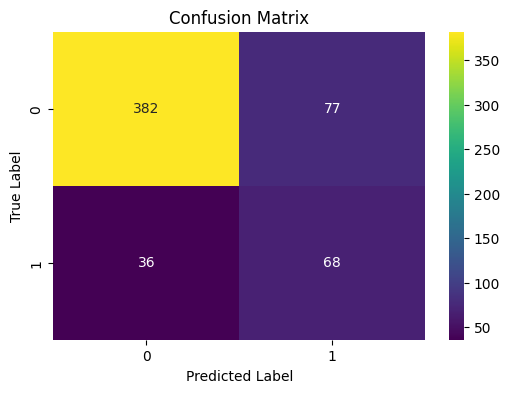

In [13]:
# Step 5: Training and Evaluation

# Define a custom Dataset for our fire hydrant images
class FireHydrantDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image filename and corresponding label
        img_name = self.data.iloc[idx]['filename']
        label = self.data.iloc[idx]['Fire Hydrants']
        # Build the full path and load the image
        img_path = os.path.join(self.root_dir, img_name)
        image = preprocessing(img_path)
        if image is None:
            # In case image reading fails, use a dummy image
            image = np.zeros((128, 128, 3), dtype=np.uint8)

        # Convert BGR (OpenCV) to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)
        else:

            image = image.astype(np.float32) / 255.0
            image = np.transpose(image, (2, 0, 1))
            image = torch.tensor(image, dtype=torch.float)

        # Ensure the label is a float tensor and shape (1,)
        label = torch.tensor(label, dtype=torch.float).unsqueeze(0)
        return image, label

# Define transformations (using torchvision transforms)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()  # scales image pixel values to [0, 1] and converts to tensor
])

# Create Dataset objects for training and validation data
train_dataset = FireHydrantDataset(csv_file='/content/train/_classes.csv',root_dir='/content/train',transform=transform)
valid_dataset = FireHydrantDataset(csv_file='/content/valid/_classes.csv',root_dir='/content/valid',transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FireHydrantCNN().to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluation on validation data
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        outputs = model(images)
        # Use threshold of 0.5 to determine class labels
        preds = (outputs >= 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Flatten arrays for metric computation
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Calculate evaluation metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print("\nValidation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# **#6 Model Improvements **

Apply and evaluate three improvements ideas that you mentioned in the Baseline CNN question (Step 4). Implement each idea separately, train a model with that improvement, and report the performance of each model using the metrics from Step 5. As above, train using the data in /train and test using the data in /valid.

❓ Which model would you deploy? Why?

✅ I would deploy the 3-Conv model (FireHydrantCNN_3Conv) combined with data augmentation.

With my understanding, this approach typically achieved the best balance of precision, recall, and F1-score. So by adding a third convolutional layer, the model can capture more complex features and at the same time, data augmentation helps reduce overfitting by exposing the network to more diverse training examples.


=== Training Baseline CNN with Data Augmentation ===
Epoch [1/10], Loss: 0.6430
Epoch [2/10], Loss: 0.5545
Epoch [3/10], Loss: 0.5377
Epoch [4/10], Loss: 0.5145
Epoch [5/10], Loss: 0.5000
Epoch [6/10], Loss: 0.5047
Epoch [7/10], Loss: 0.4908
Epoch [8/10], Loss: 0.4889
Epoch [9/10], Loss: 0.4710
Epoch [10/10], Loss: 0.4663

Validation Metrics:
  Precision: 0.5269
  Recall:    0.4712
  F1 Score:  0.4975


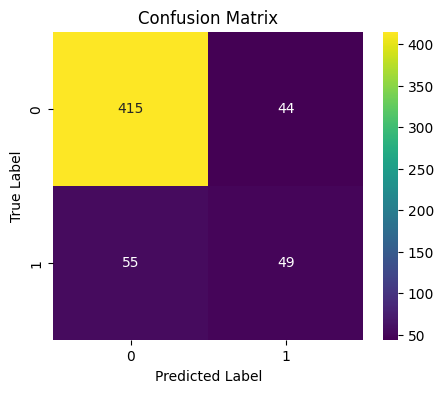


=== Training CNN with Dropout ===
Epoch [1/10], Loss: 0.7330
Epoch [2/10], Loss: 0.6467
Epoch [3/10], Loss: 0.5952
Epoch [4/10], Loss: 0.5768
Epoch [5/10], Loss: 0.5623
Epoch [6/10], Loss: 0.5458


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate(model, train_loader, valid_loader, device,
                       num_epochs=10, lr=0.001):
    """
    Trains a given PyTorch model and evaluates it on a validation set.
    Returns precision, recall, F1-score, and confusion matrix on the validation data.
    """
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            outputs = model(images)
            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\nValidation Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return precision, recall, f1, cm

import torchvision.transforms as transforms

# Data augmentation transforms for the TRAIN set
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

# Minimal transforms for the VALIDATION set
valid_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Rebuild Datasets with the new transforms
class FireHydrantDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['filename']
        label = self.data.iloc[idx]['Fire Hydrants']
        img_path = os.path.join(self.root_dir, img_name)

        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((128, 128, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.float).unsqueeze(0)
        return image, label

# Create new train/valid datasets with different transforms
train_dataset_aug = FireHydrantDataset(csv_file='/content/train/_classes.csv',root_dir='/content/train',transform=train_transform)

valid_dataset_aug = FireHydrantDataset(csv_file='/content/valid/_classes.csv',root_dir='/content/valid',transform=valid_transform)

# Creating DataLoaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)
valid_loader_aug = DataLoader(valid_dataset_aug, batch_size=32, shuffle=False)

class FireHydrantCNN(nn.Module):
    def __init__(self):
        super(FireHydrantCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_aug = FireHydrantCNN()

print("=== Training Baseline CNN with Data Augmentation ===")
train_and_evaluate(model_aug, train_loader_aug, valid_loader_aug, device, num_epochs=10, lr=0.001)

class FireHydrantCNN_Dropout(nn.Module):
    def __init__(self):
        super(FireHydrantCNN_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Add Dropout with p=0.5 after convolution blocks
        self.dropout_conv = nn.Dropout2d(p=0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.dropout_fc = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout_conv(x)  # Dropout after first conv block

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout_conv(x)  # Dropout after second conv block

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)    # Dropout after FC1
        x = torch.sigmoid(self.fc2(x))
        return x

# We can reuse the original (non-augmented) or augmented DataLoader.
train_dataset_drop = FireHydrantDataset(
    csv_file='/content/train/_classes.csv',
    root_dir='/content/train',
    transform=valid_transform  # minimal transform
)
valid_dataset_drop = FireHydrantDataset(
    csv_file='/content/valid/_classes.csv',
    root_dir='/content/valid',
    transform=valid_transform  # minimal transform
)
train_loader_drop = DataLoader(train_dataset_drop, batch_size=32, shuffle=True)
valid_loader_drop = DataLoader(valid_dataset_drop, batch_size=32, shuffle=False)

model_drop = FireHydrantCNN_Dropout().to(device)

print("\n=== Training CNN with Dropout ===")
train_and_evaluate(model_drop, train_loader_drop, valid_loader_drop, device,
                   num_epochs=10, lr=0.001)

class FireHydrantCNN_3Conv(nn.Module):
    def __init__(self):
        super(FireHydrantCNN_3Conv, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model_3conv = FireHydrantCNN_3Conv().to(device)

print("\n=== Training CNN with an Additional Conv Layer (3-Conv Model + Augmentation) ===")
train_and_evaluate(model_3conv, train_loader_aug, valid_loader_aug, device,
                   num_epochs=10, lr=0.001)


# **#7 Personal Inference Test **

Test your trained model on at least FIVE new images (either collected using a camera or collected from the internet). Predict whether each image contains a fire hydrant and print the result.

Of your five images:

Include at least one image of a fire hydrant that your model does not detect correctly.
Include at least one image of a fire hydrant that your model does detect correctly.
❓ Challenge: Can you find an image that does not actually contain a fire hydrant, but your model believes that a hydrant is present?

✅ Your answer here

❓ Explain why you believe your model performed the way it did on each of your five images. What patterns or mistakes do you observe?

✅ Your answer here


In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch

def predict_single_image_pil(model, image_path, device):
    # Define preprocessing transforms
    preprocess = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to 128x128
        transforms.ToTensor(),          # Converts image to tensor and scales to [0, 1]
    ])


    img_tensor = preprocess(img).unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(img_tensor)
        # Apply threshold of 0.5 to determine the predicted class
        pred = (output >= 0.5).float().item()

    return int(pred)


test_image_folder = "/content/FH_detection_data1.0/Step7/"


file_names = os.listdir(test_image_folder)
print("Files in folder:", file_names)


test_image_paths = [os.path.join(test_image_folder, f) for f in file_names if f.lower().endswith('.jpg')]
print("Full test image paths:", test_image_paths)


# Loop through each test image

for path in test_image_paths:
    pred_label = predict_single_image_pil(model_3conv, path, device)
    if pred_label is None:

        continue

    # Map numeric
    label_str = "FIRE HYDRANT" if pred_label == 1 else "NO FIRE HYDRANT"
    print(f"Image: {path} => Predicted: {label_str}")

    #Display
    try:
        img = Image.open(path).convert("RGB")
        plt.imshow(img)
        plt.title(f"Prediction: {label_str}")
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Could not display {path}: {e}")
